In [1]:
!pip install tensorflow opencv-python matplotlib

INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.


ERROR: Could not find a version that satisfies the requirement numpy<2.2.0,>=1.26.0 (from tensorflow) (from versions: none)
ERROR: No matching distribution found for numpy<2.2.0,>=1.26.0


In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
#Set GPU Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [7]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw-funneled.tgz

In [8]:
for directory in os.listdir('lfw_funneled'):
    dir_path = os.path.join('lfw_funneled', directory)
    if os.path.isdir(dir_path):
        for file in os.listdir(dir_path):
            EX_PATH = os.path.join(dir_path, file)
            NEW_PATH = os.path.join(NEG_PATH, file)
            os.replace(EX_PATH, NEW_PATH)


In [9]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [10]:
import os
import uuid
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\eed9e434-7293-11f0-bf1c-8dfcb70a0866.jpg'

In [11]:
import tensorflow as tf

ANC_PATH = "C:/Users/MDTANVIR/face_Authentication/data/anchor"
POS_PATH = "C:/Users/MDTANVIR/face_Authentication/data/positive"
NEG_PATH = "C:/Users/MDTANVIR/face_Authentication/data/negative"

anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(3000)

print("✅ Dataset listing successful.")





✅ Dataset listing successful.


In [12]:
dir_test = anchor.as_numpy_iterator()

In [13]:
print(dir_test.next())

b'C:\\Users\\MDTANVIR\\face_Authentication\\data\\anchor\\5c16bd15-b105-4509-be09-1cbe5fd41d92.jpg'


In [14]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [15]:
img = preprocess('C:\\Users\\MDTANVIR\\face_Authentication\\data\\anchor\\Weixin Image_202507280016214.jpg')

In [16]:
img.numpy().max()

1.0

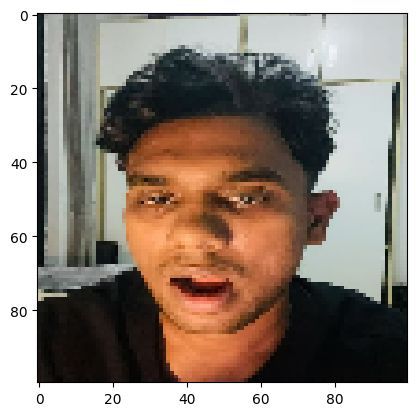

In [17]:
plt.imshow(img)

In [18]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [19]:
samples = data.as_numpy_iterator()

In [20]:
exampple = samples.next()

In [21]:
exampple

(b'C:\\Users\\MDTANVIR\\face_Authentication\\data\\anchor\\Weixin Image_202507280016191.jpg',
 b'C:\\Users\\MDTANVIR\\face_Authentication\\data\\positive\\Weixin Image_202507280025333.jpg',
 1.0)

In [22]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [23]:
res = preprocess_twin(*exampple)

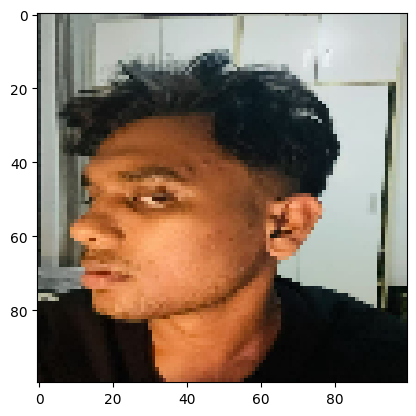

In [24]:
plt.imshow(res[1])

In [25]:
res[2]

1.0

In [26]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [27]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [28]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [29]:
inp = Input(shape=(100,100,3), name='input_image')

In [30]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [31]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [32]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [33]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [34]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [35]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [36]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [38]:
embedding = make_embedding()

In [39]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense
from tensorflow.keras.models import Model

# Siamese L1 Distance Layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, inputs):
        input_embedding, validation_embedding = inputs
        return tf.math.abs(input_embedding - validation_embedding)


In [41]:
# Example embedding model (you should replace with your own CNN if needed)
def make_embedding_model():
    inputs = Input(shape=(100, 100, 3))
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(4096, activation='relu')(x)
    return Model(inputs, x, name="Embedding")

# Build the Siamese Network
embedding = make_embedding_model()

# Inputs
input_image = Input(name='input_img', shape=(100, 100, 3))
validation_image = Input(name='validation_img', shape=(100, 100, 3))

# Embeddings
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

# Distance Layer
siamese_layer = L1Dist()
distances = siamese_layer((inp_embedding, val_embedding))  # Pass as tuple

# Classification Layer
classifier = Dense(1, activation='sigmoid')(distances)

# Final Model
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

# Summary
siamese_network.summary()


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Embedding (Functional)        │ (None, 4096)              │     277,428,096 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist (L1Dist)              │ (None, 4096)              │               0 │ Embedding[0][0],           │
│                               │                           │                 │ Embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 277,432,193 (1.03 GB)

 Trainable params: 277,432,193 (1.03 GB)

 Non-trainable params: 0 (0.00 B)

In [42]:
def make_siamese_model(): 
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100, 100, 3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100, 100, 3))
    
    # Generate embeddings
    inp_embedding = embedding(input_image)
    val_embedding = embedding(validation_image)
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer([inp_embedding, val_embedding])  # Pass as list or tuple
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    # Build model
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [43]:
siamese_model = make_siamese_model()

In [44]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Embedding (Functional)        │ (None, 4096)              │     277,428,096 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (None, 4096)              │               0 │ Embedding[2][0],           │
│                               │                           │                 │ Embedding[3][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 277,432,193 (1.03 GB)

 Trainable params: 277,432,193 (1.03 GB)

 Non-trainable params: 0 (0.00 B)

In [45]:
#Training

binary_cross_loss = tf.losses.BinaryCrossentropy()

In [46]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [47]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [48]:
test_batch = train_data.as_numpy_iterator()

In [49]:
batch_1 = test_batch.next()

In [50]:
X = batch_1[:2]

In [51]:
y = batch_1[2]

In [52]:
y

array([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1.],
      dtype=float32)

In [53]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [54]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [55]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [56]:
EPOCHS = 40

In [57]:
train(train_data, EPOCHS)


 Epoch 1/40
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
19/20 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepTensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
1/1 ━

In [58]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [59]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [60]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


In [61]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]

In [62]:
y_true

array([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

In [63]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [64]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [65]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1.0 1.0


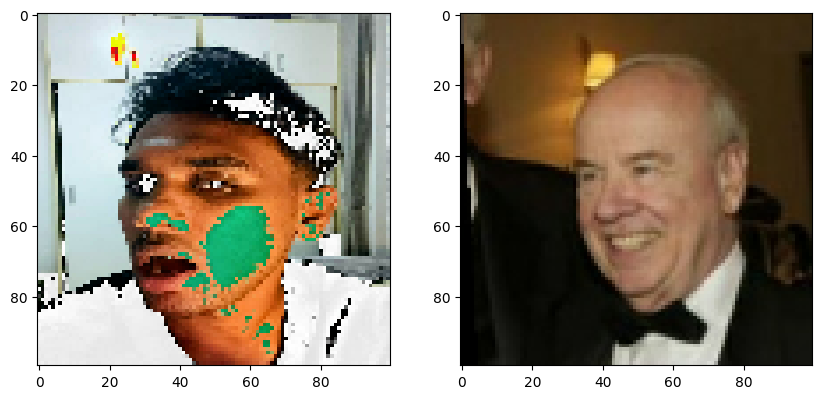

In [66]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [69]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [70]:
L1Dist

__main__.L1Dist

In [71]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [72]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


array([[2.8048234e-07],
       [9.9999988e-01],
       [1.6477132e-10],
       [3.3303422e-08],
       [1.4561164e-06],
       [5.9790233e-12],
       [5.2041862e-08],
       [4.7989047e-08]], dtype=float32)

In [105]:
# View model summary
siamese_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Embedding (Functional)        │ (None, 256)               │      18,950,272 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_4 (L1Dist)            │ (None, 256)               │               0 │ Embedding[0][0],           │
│                               │                           │                 │ Embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_9 (Dense)               │ (None, 1)                 │             257 │ l1_dist_4[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 18,950,529 (72.29 MB)

 Trainable params: 18,950,529 (72.29 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
## real time varification
r"application_data\verification_images"


'application_data\\verification_images'

In [83]:
os.listdir(os.path.join('application_data', 'verification_images'))

['Weixin Image_20250728002336.jpg',
 'Weixin Image_20250728002526.jpg',
 'Weixin Image_202507280025261.jpg',
 'Weixin Image_20250728002527.jpg',
 'Weixin Image_202507280025271.jpg',
 'Weixin Image_202507280025272.jpg',
 'Weixin Image_202507280025273.jpg',
 'Weixin Image_202507280025274.jpg',
 'Weixin Image_20250728002528.jpg',
 'Weixin Image_202507280025281.jpg',
 'Weixin Image_202507280025282.jpg',
 'Weixin Image_202507280025283.jpg',
 'Weixin Image_202507280025284.jpg',
 'Weixin Image_20250728002529.jpg',
 'Weixin Image_202507280025291.jpg',
 'Weixin Image_202507280025292.jpg',
 'Weixin Image_202507280025293.jpg',
 'Weixin Image_20250728002530.jpg',
 'Weixin Image_202507280025301.jpg',
 'Weixin Image_202507280025302.jpg',
 'Weixin Image_202507280025303.jpg',
 'Weixin Image_202507280025304.jpg',
 'Weixin Image_20250728002531.jpg',
 'Weixin Image_202507280025311.jpg',
 'Weixin Image_202507280025312.jpg',
 'Weixin Image_202507280025313.jpg',
 'Weixin Image_202507280025314.jpg',
 'Weixin

In [84]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [85]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\Weixin Image_20250728002336.jpg
application_data\verification_images\Weixin Image_20250728002526.jpg
application_data\verification_images\Weixin Image_202507280025261.jpg
application_data\verification_images\Weixin Image_20250728002527.jpg
application_data\verification_images\Weixin Image_202507280025271.jpg
application_data\verification_images\Weixin Image_202507280025272.jpg
application_data\verification_images\Weixin Image_202507280025273.jpg
application_data\verification_images\Weixin Image_202507280025274.jpg
application_data\verification_images\Weixin Image_20250728002528.jpg
application_data\verification_images\Weixin Image_202507280025281.jpg
application_data\verification_images\Weixin Image_202507280025282.jpg
application_data\verification_images\Weixin Image_202507280025283.jpg
application_data\verification_images\Weixin Image_202507280025284.jpg
application_data\verification_images\Weixin Image_20250728002529.jpg
application_data\verifica

In [86]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [90]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        breakqq
cap.release()
cv2.destroyAllWindows()

NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: application_data\input_image\input_image.jpg : The system cannot find the path specified.
; No such process [Op:ReadFile]

In [87]:
np.sum(np.squeeze(results) > 0.9)

NameError: name 'results' is not defined

In [88]:
results

NameError: name 'results' is not defined